### Instructor Demo: Financial Forecasting Part II

This program executes `1000` simulations of stock price trajectory over the next `252 * 3` trading days (or 3 years of trading) for `TSLA` stock, based on a normal probability distribution of average daily returns derived from the sample mean and standard deviation. Then, the program calculates a `95%` confidence interval of stock price outcomes for `TSLA`. 

In [1]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [2]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

### Check Available Tickers from Alpaca Markets API

In [3]:
# Get all Assets
assets = api.list_assets()

# Keep only tradeable assets
tradeable = [asset for asset in assets if asset.tradable ]
tradeable

[Asset({   'class': 'us_equity',
     'easy_to_borrow': False,
     'exchange': 'NYSE',
     'id': '2ad15d25-a851-44c9-891f-d19e54a905d5',
     'marginable': True,
     'name': 'Arbor Realty Trust, Inc 8.250% Series A Cumulative Redeemable '
             'Preferred Stock',
     'shortable': False,
     'status': 'active',
     'symbol': 'ABR-A',
     'tradable': True}),
 Asset({   'class': 'us_equity',
     'easy_to_borrow': False,
     'exchange': 'NYSE',
     'id': 'b769adcd-7514-4e56-85ee-dabc29e801e4',
     'marginable': True,
     'name': 'Arbor Realty Trust, Inc. 7.75% Series B Preferred',
     'shortable': False,
     'status': 'active',
     'symbol': 'ABR-B',
     'tradable': True}),
 Asset({   'class': 'us_equity',
     'easy_to_borrow': False,
     'exchange': 'NASDAQ',
     'id': 'add2d2c9-fce7-4155-a232-5ae7470e7178',
     'marginable': True,
     'name': 'Arch Capital Group Ltd. Depositary Shares Each Representing '
             '1/1,000th Interest in a Share of 5.45% Non

In [4]:
# Create a new empty DataFrame
asset_info_df = pd.DataFrame()
asset_info_df['symbol'] = pd.Series([asset.symbol for asset in assets])

# Display the first 10 asset tickers
display(asset_info_df.head(10))

,symbol
0,ABILF
1,ABR-A
2,ABR-B
3,ACGLO
4,ACIA
5,KTP
6,ACIO
7,LVHE
8,ACIU
9,ACLS


### Get 1 Year's Worth of Data via API Call and Read in as DataFrame 

In [5]:
# Set the ticker
ticker = "TSLA"

# Set timeframe to '1D'
timeframe = '1D'

# Set start and end datetimes of 1 year, between now and 365 days ago.
end_date = datetime.now()
start_date = end_date + timedelta(-365)

# Format end_date and start_date with isoformat
end_date = pd.Timestamp(end_date, tz="America/New_York").isoformat()
start_date = pd.Timestamp(start_date, tz="America/New_York").isoformat()

# Get 1 year's worth of historical data for TSLA
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

df.head()

TSLA                                       
                             open      high       low    close    volume
2019-05-31 00:00:00-04:00  185.10  189.9204  184.1000  185.480   9599948
2019-06-03 00:00:00-04:00  185.51  186.6800  176.9919  179.010  12380263
2019-06-04 00:00:00-04:00  181.10  193.9800  179.6100  193.910  13115692
2019-06-05 00:00:00-04:00  198.47  201.2782  191.8486  196.677  12570739
2019-06-06 00:00:00-04:00  204.25  211.0000  201.8000  206.080  19472101

### Drop Extraneous Columns

In [6]:
# Drop Outer Table Level
df = df.droplevel(axis=1, level=0)

# Use the drop function to drop extra columns
df.drop(columns=['open', 'high', 'low', 'volume'], inplace=True)

# Since this is daily data, we can keep only the date (remove the time) component of the data
df.index = df.index.date

df.head()

,close
2019-05-31,185.480
2019-06-03,179.010
2019-06-04,193.910
2019-06-05,196.677
2019-06-06,206.080


### Calculate Daily Returns

In [7]:
# Use the `pct_change` function to calculate daily returns of TSLA
daily_returns = df.pct_change()
daily_returns.head()

,close
2019-05-31,NaN
2019-06-03,-0.034882
2019-06-04,0.083236
2019-06-05,0.014270
2019-06-06,0.047809


### Calculate Value of Average Daily Returns

In [8]:
# Use the `mean` function to calculate the mean of daily returns for TSLA
avg_daily_return = daily_returns.mean()['close']
avg_daily_return

0.007164887581771919

### Calculate Value of Standard Deviation of Daily Returns

In [9]:
# Use the `std` function to calculate the standard deviation of daily returns for TSLA
std_dev_daily_return = daily_returns.std()['close']
std_dev_daily_return

0.0481628844575466

### Run the Monte Carlo Simulation and Save Results to DataFrame

In [12]:
# Set number of simulations, trading days, and get last closing price of TSLA from DataFrame
num_simulations = 1000
num_trading_days = 252 * 3
tsla_last_price = df['close'][-1]

# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_price_df = pd.DataFrame()

# Run the simulation of projecting stock prices for the next trading year, `1000` times
for n in range(num_simulations):

    # Initialize the simulated prices list with the last closing price of TSLA
    simulated_tsla_prices = [tsla_last_price]
    
    # Simulate the returns for 252 * 3 days
    for i in range(num_trading_days):
        # Calculate the simulated price using the last price within the list
        simulated_price = simulated_tlsa_prices[-1] * (1 + np.random.normal(avg_daily_return, std_dev_daily_return))
        # Append the simulated price to the list
        simulated_tsla_prices.append(simulated_price)
    
    # Append the simulated prices of each simulation to DataFrame
    simulated_price_df[f"Simulation {n+1}"] = pd.Series(simulated_tsla_prices)

# Print head of DataFrame
simulated_price_df.head()

,Simulation 1,Simulation 2,Simulation 3,Simulation 4,Simulation 5,Simulation 6,Simulation 7,Simulation 8,Simulation 9,Simulation 10,...,Simulation 991,Simulation 992,Simulation 993,Simulation 994,Simulation 995,Simulation 996,Simulation 997,Simulation 998,Simulation 999,Simulation 1000
0,834.190500,834.190500,834.190500,834.190500,834.190500,834.190500,834.190500,834.190500,834.190500,834.190500,...,834.190500,834.190500,834.190500,834.190500,834.190500,834.190500,834.190500,834.190500,834.190500,834.190500
1,860.849940,833.535140,857.318155,842.114152,858.535836,852.514600,878.174659,793.541166,802.572452,857.216729,...,931.134536,887.726088,853.478408,823.744591,846.199305,844.449430,860.778293,879.490286,837.121063,775.659260
2,805.435747,850.998358,868.114712,849.072720,818.283189,816.136903,827.836390,798.078861,837.924648,859.651258,...,817.251973,827.642177,857.348145,899.246537,846.343495,814.035049,900.219573,861.328047,900.134053,918.632333
3,779.979488,883.413334,799.238070,843.766232,895.630917,864.632779,847.469349,866.518014,829.053511,832.600016,...,902.913689,861.740279,867.767242,865.186136,893.555425,781.928866,838.484992,843.215933,887.254720,866.462606
4,861.111825,887.126070,772.691662,863.875836,894.153073,852.797175,761.917241,832.670829,805.811750,854.477205,...,857.931710,825.846169,801.489786,826.587730,871.690448,774.121529,804.284330,849.900083,855.354436,873.028834


### Plot the Multiple Simulations of Stock Price Trajectory for TSLA over the Next 3 Years (252 * 3 Trading Days)

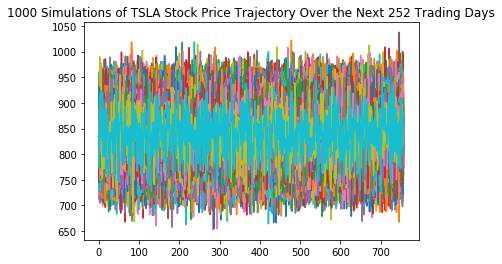

In [13]:
# Use the `plot` function to plot the trajectory of TSLA stock based on a 252 * 3 trading day simulation
plot_title = f"{n+1} Simulations of TSLA Stock Price Trajectory Over the Next 252 Trading Days"
simulated_price_df.plot(legend=None, title=plot_title)

In [14]:
# Select the last row for projecting stock prices (prices of each simulation on the last simulated trading day)
simulated_ending_prices = simulated_price_df.iloc[-1, :]
simulated_ending_prices.head()

Simulation 1    848.322424
Simulation 2    814.656077
Simulation 3    841.477181
Simulation 4    811.682423
Simulation 5    828.110904
Name: 756, dtype: float64

### Plot the Frequency Distribution of Simulated Ending Prices on the Last Simulated Trading Day

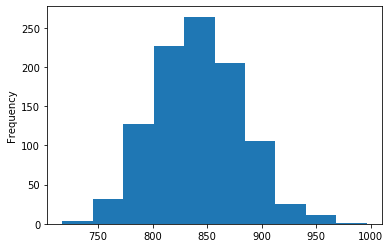

In [15]:
# Use the `plot` function to plot a frequency distribution of simulated ending prices
simulated_ending_prices.plot(kind='hist')

### View the Probability Distribution of Simulated Ending Price Ranges on the Last Simualted Trading Day

In [16]:
# Use the `value_counts` function to create the frequency distribution and 
# sort the data into 20 bins. Divide the value counts of each bin by the total
# number of prices to return the probability of each range


(-3587.1530000000002, 187527.926]    0.908
(187527.926, 374895.65]              0.056
(374895.65, 562263.373]              0.014
(562263.373, 749631.096]             0.006
(749631.096, 936998.82]              0.004
(936998.82, 1124366.543]             0.004
(1499101.99, 1686469.714]            0.001
(1124366.543, 1311734.267]           0.001
(1311734.267, 1499101.99]            0.001
(3560146.948, 3747514.671]           0.001
(2435940.607, 2623308.331]           0.001
(2623308.331, 2810676.054]           0.001
(2810676.054, 2998043.778]           0.001
(1686469.714, 1873837.437]           0.001
(3372779.225, 3560146.948]           0.000
(1873837.437, 2061205.16]            0.000
(2061205.16, 2248572.884]            0.000
(2248572.884, 2435940.607]           0.000
(2998043.778, 3185411.501]           0.000
(3185411.501, 3372779.225]           0.000
Name: 756, dtype: float64

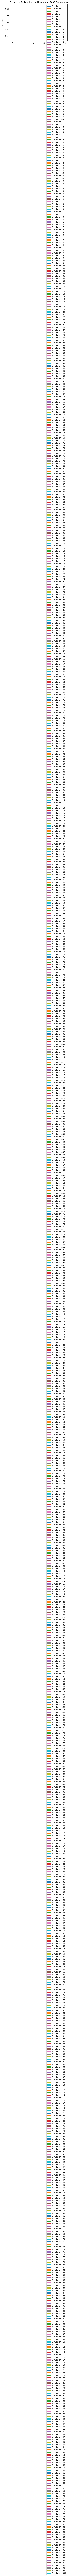

In [18]:
plot_title = f"Frequency Distribution for Heads from {num_simulations} Simulations"
simulated_price_df.plot(kind='hist', title=plot_title, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

### Calculate Lower and Upper Bounds of 95% Confidence Interval for Simulated Ending Stock Prices of TSLA

In [19]:
# Use the `quantile` function to calculate the 95% confidence interval for simulated ending prices
confidence_interval = simulated_price_df.quantile(q=[0.025, 0.975])
confidence_interval

,Simulation 1,Simulation 2,Simulation 3,Simulation 4,Simulation 5,Simulation 6,Simulation 7,Simulation 8,Simulation 9,Simulation 10,...,Simulation 991,Simulation 992,Simulation 993,Simulation 994,Simulation 995,Simulation 996,Simulation 997,Simulation 998,Simulation 999,Simulation 1000
0.025,762.516105,757.935806,757.913555,763.270537,754.849268,765.231142,758.664069,766.564871,759.881194,760.060445,...,761.785037,765.781171,762.397054,759.778379,761.495703,762.930971,759.707675,756.708826,757.227158,758.311529
0.975,925.356445,919.300078,920.382865,919.934376,920.566506,914.000022,915.625278,913.331632,921.620284,916.391789,...,916.739225,917.232291,917.488952,924.805088,918.539462,922.473156,920.767123,919.946644,910.336448,918.806863


### Plot the Probability Distribution and 95% Confidence Interval of Simulated Ending Prices 

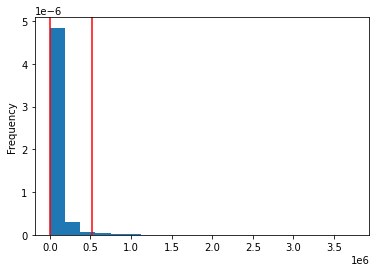

In [18]:
# Use the `plot` function to create a probability distribution histogram of simulated ending prices
# with markings for a 95% confidence interval






### Calculate 95% Confidence Interval of An Initial Investment of 10,000 in TSLA over the Next 3 Years (252 * 3) Trading Days

In [19]:
# Set initial investment


# Calculate cumulative profit/loss of lower and upper bound


# Add the initial investment to the cumulative profit/loss of lower and upper bound



# Print the results




There is a 95% chance that an initial investment of $10,000 in TSLA over the next (252 * 3) trading days will end within in the range of $15930.407516701456 and $10095493.147461772
